# This file contains :
## 1. Plot trajectories
## 2. Compute transformation matrix

In [24]:
import numpy as np
sys.path.append("../")
import csv
import os
import scipy
from scipy.spatial.transform import Rotation as R_scipy
from datetime import datetime, timezone
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Ellipse
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable
import warnings
import importlib
import scripts.theodolite_utils as theodo_u
theodo_u = importlib.reload(theodo_u)
warnings.filterwarnings('ignore')


In [71]:
date = "20220711-1"
path = "../data/"+ date + "/"

## 1. Plot Trajectories, data frames contains :

point ID,
Easting,
Northing,
Orthometric Altitude (CGVD28),
Horizontal Precision,
Vertical Precision,
PDOP,
Sats,
Date,
Time

In [72]:
df1 = pd.read_csv(path + 'gps_data/gps1.txt', names=['Time','Easting','Northing','Elevation','Qx','Qy','Qz','Qw'], header=0, delimiter= ' ')
df2 = pd.read_csv(path + 'gps_data/gps2.txt',names=['Time','Easting','Northing','Elevation','Qx','Qy','Qz','Qw'], header=0, delimiter= ' ')
df3 = pd.read_csv(path + 'gps_data/gps3.txt',names=['Time','Easting','Northing','Elevation','Qx','Qy','Qz','Qw'], header=0, delimiter= ' ')

## 1.0 Compute Timestamp from Time

## 1.1 Plot GNSS trajectory 1

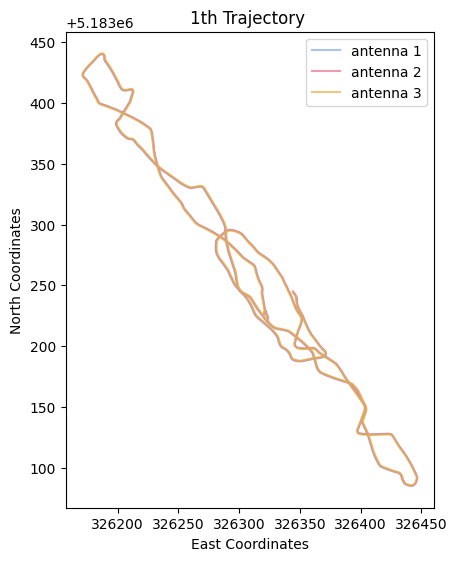

In [73]:
# 2D figure
%matplotlib inline
fig, axs = plt.subplots(figsize=(10, 5.5), nrows=1, ncols=1, constrained_layout = True)
axs.plot(df1['Northing'], df1['Easting'], c='#89ABE3', label='antenna 1', alpha = 0.7)
axs.plot(df2['Northing'], df2['Easting'], c='#EA738D', label='antenna 2', alpha = 0.7)
axs.plot(df3['Northing'], df3['Easting'], c='#E3B448', label='antenna 3', alpha = 0.7)

axs.set_xlabel('East Coordinates')
axs.set_ylabel('North Coordinates')
axs.set_title('1th Trajectory ')
axs.set_aspect('equal')
plt.legend()

## 2. Compute transformation matrix $T_{LIDAR}^{GNSS}$

In [75]:
theodo_u = importlib.reload(theodo_u)
sensors_positions_file = path + "sensors_extrinsic_calibration/sensor_position_lidar_frame.csv"

sensors = np.array(theodo_u.read_file(sensors_positions_file))
P1_lidar, P2_lidar, P3_lidar, G1_lidar, G2_lidar, G3_lidar = sensors[:6]

p_1 = np.array(G1_lidar)
p_2 = np.array(G2_lidar)
p_3 = np.array(G3_lidar)

p_1 = np.expand_dims(p_1, axis=1)
p_2 = np.expand_dims(p_2, axis=1)
p_3 = np.expand_dims(p_3, axis=1)

In [76]:
traj1 = pd.merge(df1[['Time', 'Easting', 'Northing', 'Elevation']], df2[['Time', 'Easting', 'Northing', 'Elevation']], on=['Time'])
traj1 = pd.merge(traj1, df3[['Time', 'Easting', 'Northing', 'Elevation']], on=['Time'])

poses = []
for i in range(len(traj1)) :
    q_1 = np.array([[traj1['Northing_x'][i]], [traj1['Easting_x'][i]], [traj1['Elevation_x'][i]], [1]])
    q_2 = np.array([[traj1['Northing_y'][i]], [traj1['Easting_y'][i]], [traj1['Elevation_y'][i]], [1]])
    q_3 = np.array([[traj1['Northing'][i]], [traj1['Easting'][i]], [traj1['Elevation'][i]], [1]])

    P = np.hstack([p_1, p_2, p_3])
    Q = np.hstack([q_1, q_2, q_3])
    T = theodo_u.point_to_point_minimization(P,Q)
    R = T[0:3, 0:3]
    t = T[0:3, 3]
    Rot = R_scipy.from_matrix(R)
    quat = Rot.as_quat()
    poses.append([t[0], t[1], t[2], quat[0], quat[1], quat[2], quat[3]])

traj1['X'], traj1['Y'], traj1['Z'], traj1['qx'], traj1['qy'], traj1['qz'], traj1['qw'] = zip(*poses)

traj1 = traj1[['Time','X','Y','Z','qx','qy','qz', 'qw']]

In [77]:
path1 = path + "ground_truth/groundtruth_gps_lidar.csv" 
traj1.to_csv(path1, index=False)

## 2.1 Plot transformation matrix $T_{LIDAR}^{GNSS}$


In [ ]:
%matplotlib widget
fig, axs = plt.subplots(figsize=(12, 7), nrows=1, ncols=3, constrained_layout = True)
ax = axs[0]
ax2 = axs[1]
ax3 = axs[2]


# ax.quiver(X, Y, U, V, angles='xy', scale_units='xy', scale=0.3, color='red', width=0.005)
# ax.quiver(X, Y, V, U, angles='xy', scale_units='xy', scale=0.3, color='green', width=0.005)
ax.scatter(traj1['X'],traj1['Y'], c=traj1['Sats'], cmap='plasma', s=traj1['PDOP']*8, alpha=0.7)

# ax.quiver(X, Y, U, V, angles='xy', scale_units='xy', scale=0.3, color='red', width=0.005)
# ax.quiver(X, Y, V, U, angles='xy', scale_units='xy', scale=0.3, color='green', width=0.005)
ax2.scatter(traj2['X'],traj2['Y'], c=traj2['Sats'], cmap='plasma', s=traj2['PDOP']*8, alpha=0.7)

# ax.quiver(X, Y, U, V, angles='xy', scale_units='xy', scale=0.3, color='red', width=0.005)
# ax.quiver(X, Y, V, U, angles='xy', scale_units='xy', scale=0.3, color='green', width=0.005)
ax3.scatter(traj3['X'],traj3['Y'] , c=traj3['Sats'], cmap='plasma', s=traj3['PDOP']*8, alpha=0.7)
     
legend_elements = [
    Line2D([0], [0], marker='o', color='white', markerfacecolor='indigo', markersize=7, label='Robot trajectory')]

ax.set_xlim()
ax.set_ylim()
ax.legend(handles=legend_elements, loc='lower left')
ax.ticklabel_format(useOffset=False)
ax.set_xlabel('East')
ax.set_ylabel('North')
ax.set_aspect('equal')
ax.set_title('1th robot trajectory')

ax2.set_xlim()
ax2.set_ylim()
ax2.legend(handles=legend_elements, loc='lower left')
ax2.ticklabel_format(useOffset=False)
ax2.set_xlabel('East')
ax2.set_ylabel('North')
ax2.set_aspect('equal')
ax2.set_title('2nd robot trajectory')

ax3.set_xlim()
ax3.set_ylim()
ax3.legend(handles=legend_elements, loc='lower left')
ax3.ticklabel_format(useOffset=False)
ax3.set_xlabel('East')
ax3.set_ylabel('North')
ax3.set_aspect('equal')
ax3.set_title('3rd robot trajectory')

plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.setp(ax2.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.setp(ax3.get_xticklabels(), rotation=30, horizontalalignment='right')

plt.show()